# Pneumonia Keras Notebook

This notebook tries to create a Keras model that can distinguish between pneumonia ill lungs or healthy lungs by using a radiography image as input.

Created by: Sergio Teso Lorenzo

## Libraries and modules

In [1]:
import pandas as pd # Data import, manipulation and processing 
import numpy as np # Vector and Matrix library
import matplotlib.pyplot as plt # Graph making
import os # System functions
import glob # Unix style pathname pattern expansion
from pathlib import Path # Path manipulation
from skimage.io import imread # Scikit image library: Reads an image
from skimage.transform import resize # Scikit image library: Resizes an image
import seaborn as sns # graphics library 

# Keras libraries
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img # keras image manipulation
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks.callbacks import Callback
from keras.callbacks.callbacks import ModelCheckpoint
from keras.models import load_model


# Sklearn
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import roc_curve,roc_auc_score

# Shows matplotlib graphs in the notebook
%matplotlib inline 

Using TensorFlow backend.


## Data import and visualization

In [3]:
from itertools import cycle

# Path to data folder
data_folder = Path("../data/chest_xray")

# Paths to the train, test and validation folders
train_folder = data_folder / "train"
test_folder = data_folder / "test"
val_folder = data_folder / "val"

folder_list = [train_folder, test_folder, val_folder]

# constant values
normal_sufix = "NORMAL"
pneu_sufix = "PNEUMONIA"
columns = ['image','type', 'label']
types = ['train', 'test', 'val']
labels = [0, 1]
labels_e = np.array([np.repeat(x, len(types)) for x in labels]).flatten()

normal_folder_list = [x / normal_sufix for x in folder_list]
pneu_folder_list = [x / pneu_sufix for x in folder_list]
folders = normal_folder_list + pneu_folder_list

list_dataframes = []
for folder, tipo, label in zip(folders, cycle(types), labels_e):
    data = folder.glob("*.jpeg")
    data_list = []
    for img in data:
        data_list.append((img,tipo,label))
    df = pd.DataFrame(data_list, columns = columns, index=None )
    list_dataframes.append(df)
    
combined_df = pd.concat(list_dataframes, ignore_index=True)
# Shuffle the data 
combined_df = combined_df.sample(frac=1.).reset_index(drop=True)
combined_df

,image,type,label
0,..\data\chest_xray\train\NORMAL\IM-0525-0001-0...,train,0
1,..\data\chest_xray\train\PNEUMONIA\person790_v...,train,1
2,..\data\chest_xray\train\PNEUMONIA\person1943_...,train,1
3,..\data\chest_xray\train\NORMAL\NORMAL2-IM-105...,train,0
4,..\data\chest_xray\train\NORMAL\NORMAL2-IM-039...,train,0
...,...,...,...
5851,..\data\chest_xray\train\PNEUMONIA\person605_b...,train,1
5852,..\data\chest_xray\train\NORMAL\NORMAL2-IM-114...,train,0
5853,..\data\chest_xray\train\NORMAL\IM-0209-0001.jpeg,train,0
5854,..\data\chest_xray\train\NORMAL\NORMAL2-IM-061...,train,0


In [4]:
combined_df.isnull().sum() #checking for total null values

# Transform Path values into str
str_combined_df = combined_df.copy()
str_combined_df['image'] = str_combined_df['image'].apply(lambda x: str(x))

# Separate the data into train - test - validation
train_data = str_combined_df[combined_df['type'] == 'train']
test_data = str_combined_df[combined_df['type'] == 'test']
val_data = str_combined_df[combined_df['type'] == 'val']

Total Data: 5856
Train data: 5216
Test data: 624
Validation data: 16


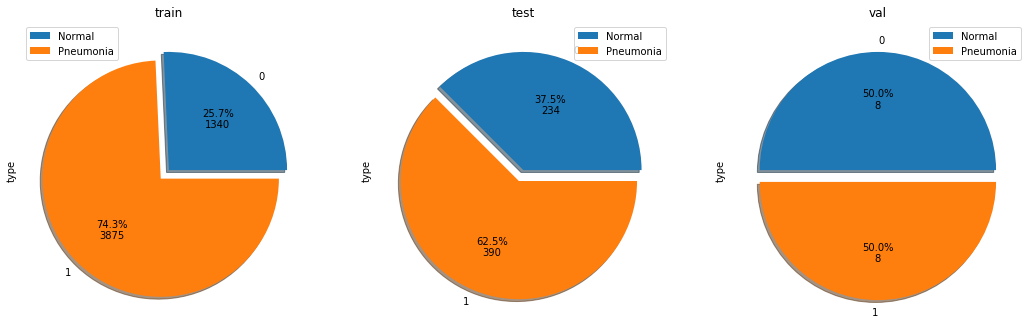

In [5]:
# Function for getting the absolute numeric value using the percentage(pct) that is calculated automatically by plot.pie
# Then returns the string with both the pct and the absolute
def func(pct, data):
    absolute = int(pct/100.*data.iloc[:,-1].sum())
    return "{:.1f}%\n{:d}".format(pct, absolute)

# prepare the figure
rows = 1
columns = 3
f,axes=plt.subplots(rows,columns,figsize=(18,8))

print("Total Data: {}".format(len(combined_df)))
print("Train data: {}".format(len(train_data)))
print("Test data: {}".format(len(test_data)))
print("Validation data: {}".format(len(val_data)))

# plot the pie charts
for data, tipo, ax in zip([train_data, test_data, val_data], types, axes):
    ax.set_title(tipo)
    data.groupby('label').count().plot.pie(y='type',
                                            autopct=lambda pct: func(pct, data.groupby('label').count()),
                                            shadow = True, explode=[0,0.1],
                                            ax = ax)
    ax.legend(['Normal', 'Pneumonia'])

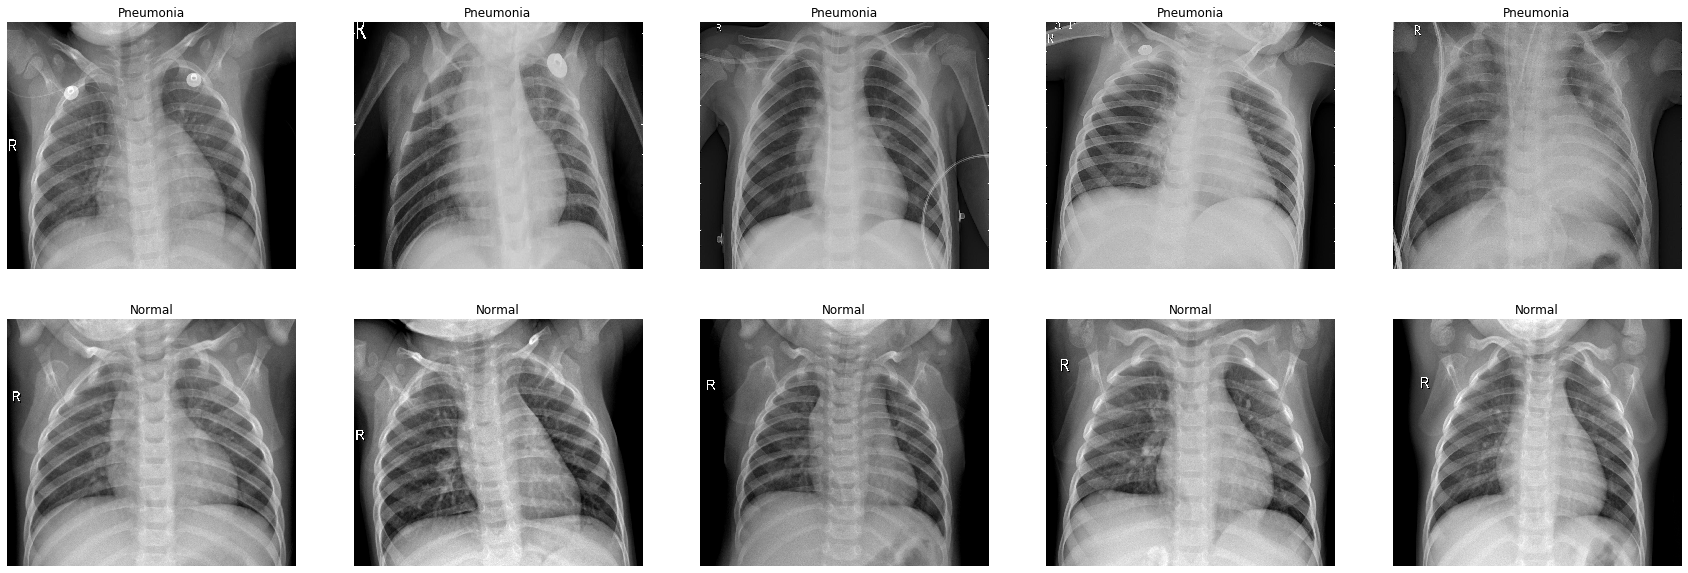

In [6]:
# Get few samples for both classes

#df[df['label'] == 1] <-> SELECT * FROM df WHERE label == 1
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist() 
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Samples parameters for the graph
rows = 2
length = len(samples)
columns = int(length/rows)

# Plot the data 
f, ax = plt.subplots(rows, columns, figsize=(30,10))
for i in range(length):
    img = imread(samples[i]) # Reads the image
    axe = ax[i//columns, i%columns] # // devuelve la parte entera de la division si es mayor el dividiendo devuelve 1
    axe.imshow(img, cmap='gray')
    if i<columns:
        axe.set_title("Pneumonia")
    else:
        axe.set_title("Normal")
    axe.axis('off')
    axe.set_aspect('auto')
plt.show()

# ETL - Extract Transform Load

Playing with the image generators

In [7]:
str_combined_df = combined_df.copy().applymap(lambda x: str(x))

train_data = str_combined_df[str_combined_df['type'] == 'train']
test_data = str_combined_df[str_combined_df['type'] == 'test']
val_data = str_combined_df[str_combined_df['type'] == 'val']

In [8]:
batch_size = 32
input_size = (64, 64)
#input_size = (128, 128)

In [9]:
# Image preprocessing generators
train_datagen = ImageDataGenerator(
    rotation_range = 40, # rotates the image 40 degrees
#     width_shift_range = 0.2, # shifts the image to the right
#     height_shift_range = 0.2, # shifts the image up
    shear_range = 0.2, # shear transformation
    zoom_range = 0.2, # zooms the image
#     horizontal_flip = True,
    rescale = 1./255) # multiply all values by the constant. In this case normalizes the data) # flips the image by the horizontal axis

validation_datagen = ImageDataGenerator(rescale=1./255)

#image data from dataframe
train_data_generation = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="image",
        y_col="label",
        batch_size=batch_size,
        target_size=input_size,
        color_mode="grayscale",
        class_mode='categorical')

test_data_generation = validation_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col="image",
        y_col="label",
        batch_size=batch_size,
        target_size=input_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle = False)

val_data_generation = validation_datagen.flow_from_dataframe(
        dataframe=val_data,
        x_col="image",
        y_col="label",
        batch_size=batch_size,
        target_size=input_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


# Model creation

### Hyper-parameters

In [41]:
input_shape = (64, 64, 1)
#input_shape = (64, 64, 3) #RGB image
#input_shape = (128, 128, 3)
kernel_size = (3, 3)
conv_activation = "relu"
filters = [32, 64, 128]
dropout = 0.1

pool_size = (2, 2)

dense_activation = ["relu", "sigmoid"]

In [42]:
cnn = Sequential()

#Convolution
cnn.add(Conv2D(filters[1], kernel_size=kernel_size, activation=conv_activation,
               input_shape=input_shape))

#Pooling
cnn.add(MaxPooling2D(pool_size = pool_size))

# 2nd Convolution
cnn.add(Conv2D(filters[1], kernel_size=kernel_size, activation=conv_activation))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = pool_size))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = dense_activation[0], units = 128))
cnn.add(Dropout(dropout))
cnn.add(Dense(activation = dense_activation[1], units = 2))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [43]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

### Fit parameters

In [13]:
epochs = 25
steps_per_epoch = len(train_data)/batch_size
test_steps = len(test_data)/batch_size
validation_steps = len(val_data)/batch_size

Early Stopping for preventing overfitting

In [45]:
class EarlyStoppingByValAccuracyAndLoss(Callback):
    def __init__(self, values=[0.98, 0.05], verbose=0):
        super(Callback, self).__init__()
        self.values = values
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        # Get val accuracy and val loss
        val_acc = logs.get("val_accuracy")
        val_loss = logs.get("val_loss")
        
        if val_acc is None or val_loss is None:
            warnings.warn("Early stopping requires val_accuracy and val_loss available!", RuntimeWarning)

        if val_acc >= self.values[0] and val_loss <= self.values[1]:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            
callbacks = [
    EarlyStoppingByValAccuracyAndLoss(values=[0.93, 0.12], verbose=1)
]

## Training process

In [46]:
cnn_hist = cnn.fit_generator(train_data_generation,
                         steps_per_epoch = steps_per_epoch,
                         epochs = epochs,
                         validation_data = val_data_generation,
                         validation_steps = validation_steps,
                         callbacks=callbacks)

Epoch 1/25
163/163 [==============================] - 50s 309ms/step - loss: 0.4457 - accuracy: 0.7402 - val_loss: 0.7358 - val_accuracy: 0.5000
Epoch 2/25
163/163 [==============================] - 50s 305ms/step - loss: 0.3439 - accuracy: 0.7590 - val_loss: 1.3982 - val_accuracy: 0.5625
Epoch 3/25
163/163 [==============================] - 50s 306ms/step - loss: 0.2635 - accuracy: 0.8894 - val_loss: 0.6525 - val_accuracy: 0.7500
Epoch 4/25
163/163 [==============================] - 50s 307ms/step - loss: 0.2142 - accuracy: 0.9137 - val_loss: 0.7087 - val_accuracy: 0.6875
Epoch 5/25
163/163 [==============================] - 50s 306ms/step - loss: 0.2068 - accuracy: 0.9185 - val_loss: 0.6308 - val_accuracy: 0.7500
Epoch 6/25
163/163 [==============================] - 50s 304ms/step - loss: 0.1873 - accuracy: 0.9266 - val_loss: 0.4823 - val_accuracy: 0.8125
Epoch 7/25
163/163 [==============================] - 50s 304ms/step - loss: 0.1712 - accuracy: 0.9321 - val_loss: 1.2046 - val_ac

## Results

In [47]:
#Confution Matrix and Classification Report
Y_pred = cnn.predict_generator(test_data_generation, test_steps, workers = 1)
# Get most likely class
y_pred = np.argmax(Y_pred, axis=1)

true_classes = test_data_generation.classes

print('Confusion Matrix')
print(confusion_matrix(true_classes, y_pred))
print('Classification Report')
target_names = ['Normal(0)', 'Pneumonia(1)']

report = classification_report(true_classes, y_pred, target_names=target_names)
print(report)

Confusion Matrix
[[213  21]
 [ 36 354]]
Classification Report
              precision    recall  f1-score   support

   Normal(0)       0.86      0.91      0.88       234
Pneumonia(1)       0.94      0.91      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.90       624
weighted avg       0.91      0.91      0.91       624



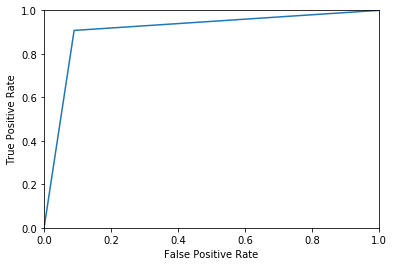

Area under the curve: 0.9089743589743589


In [48]:
# Get true positives rate (TPR = recall) and false positive rate (FPR)
fpr , tpr , thresholds = roc_curve(true_classes, y_pred)

plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()    

auc_score=roc_auc_score(true_classes, y_pred)
print("Area under the curve: {}".format(auc_score))

In [49]:
test_accu = cnn.evaluate_generator(test_data_generation,steps=validation_steps, workers = 1)
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 96.875 %


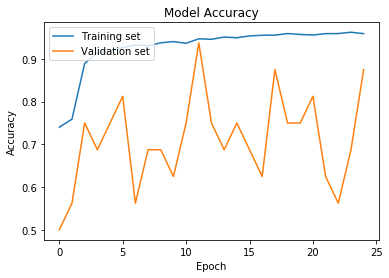

In [50]:
# Accuracy 
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

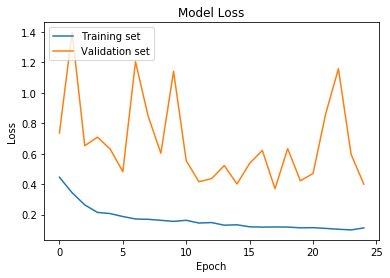

In [51]:
# Loss 

plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

## Save the model

In [29]:
filename = 'keras_cnn_penumonia.h5'

In [52]:
cnn.save(filename)

## Load model

In [30]:
model = load_model(filename)

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_data_generation, test_steps, workers = 1)
# Get most likely class
y_pred = np.argmax(Y_pred, axis=1)

true_classes = test_data_generation.classes

print('Confusion Matrix')
print(confusion_matrix(true_classes, y_pred))
print('Classification Report')
target_names = ['Normal(0)', 'Pneumonia(1)']

report = classification_report(true_classes, y_pred, target_names=target_names)
print(report)

Confusion Matrix
[[213  21]
 [ 36 354]]
Classification Report
              precision    recall  f1-score   support

   Normal(0)       0.86      0.91      0.88       234
Pneumonia(1)       0.94      0.91      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.90       624
weighted avg       0.91      0.91      0.91       624



In [31]:
test_accu = model.evaluate_generator(test_data_generation,steps=validation_steps, workers = 1)
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 96.875 %


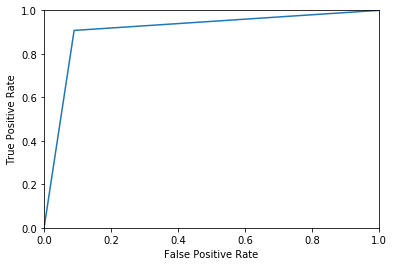

Area under the curve: 0.9089743589743589


In [32]:
# Get true positives rate (TPR = recall) and false positive rate (FPR)
fpr , tpr , thresholds = roc_curve(true_classes, y_pred)

plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()    

auc_score=roc_auc_score(true_classes, y_pred)
print("Area under the curve: {}".format(auc_score))